## Imports

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import numpy as np
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
from matplotlib import pyplot as plt, cm as c
from scipy.ndimage.filters import gaussian_filter
import scipy
import torchvision.transforms.functional as F
import torch
from torchvision import transforms, models
from tqdm import tqdm
import torch.nn as nn

## Load the video file

In [3]:
# Path to your MP4 file in Google Drive
video_path = '/content/drive/MyDrive/AC297R/earthcam_ny_video.mp4'

(720, 1280, 3)


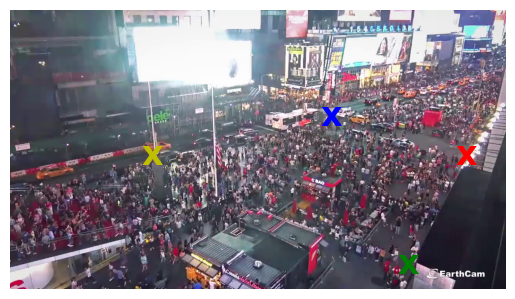

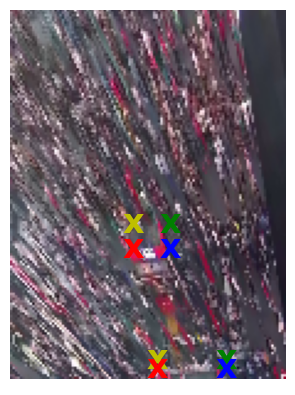

In [8]:
# Load the video
cap = cv2.VideoCapture(video_path)

# Get video frame rate
fps = cap.get(cv2.CAP_PROP_FPS)

# Desired time to get the frame (in seconds)
desired_time = 0

# Calculate the frame number based on the desired time and frame rate
frame_number = int(desired_time * fps)

# Set the video position to the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

# Convert the frame from BGR to RGB (for correct color rendering in matplotlib)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
print(frame_rgb.shape)
# Display the frame
plt.imshow(frame_rgb)
plt.annotate('x', (340, 400), c='y', fontweight=1000, fontsize=24)
plt.annotate('x', (1000, 680), c='g', fontweight=1000, fontsize=24)
plt.annotate('x', (1150, 400), c='r', fontweight=1000, fontsize=24)
plt.annotate('x', (800, 300), c='b', fontweight=1000, fontsize=24)

plt.axis('off')  # Hide axes
plt.show()

# Annotated points on the original image
src = np.float32([
    [800, 300],  # top left
    [1150, 400],   # top right
    [1000, 680], # bottom right
    [340, 400], # bottom left
])

# Destination points for the bird's-eye view
# These points should form a rectangle in the new image
dst = np.float32([
    [0, 0],   # Top-left corner
    [88, 0], # Top-right corner
    [112,150], # Bottom-right corner
    [0, 150]  # Bottom-left corner
])

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Apply the perspective transformation
warped_frame = cv2.warpPerspective(frame_rgb, M, (112, 150))

# Display the transformed frame
plt.imshow(warped_frame)

# Bao stand
plt.annotate('x', (45, 90), c='y', fontweight=1000, fontsize=24)
plt.annotate('x', (60, 90), c='g', fontweight=1000, fontsize=24)
plt.annotate('x', (45, 100), c='r', fontweight=1000, fontsize=24)
plt.annotate('x', (60, 100), c='b', fontweight=1000, fontsize=24)

# Building at exit
plt.annotate('x', (55, 145), c='y', fontweight=1000, fontsize=24)
plt.annotate('x', (83, 145), c='g', fontweight=1000, fontsize=24)
plt.annotate('x', (55, 149), c='r', fontweight=1000, fontsize=24)
plt.annotate('x', (83, 149), c='b', fontweight=1000, fontsize=24)

plt.axis('off')
plt.show()

# Release the video capture object
cap.release()

## Load the CSRNet model

In [10]:
# This is the CSRNet model (publicly available)

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [11]:
model = CSRNet()
weights_path = '/content/drive/MyDrive/AC297R/Code/csrnet/weights.pth'

checkpoint = torch.load(weights_path, map_location="cpu")
model.load_state_dict(checkpoint)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.6MB/s]


<All keys matched successfully>

## CSRNet pipeline (applied to one frame)

Original Image


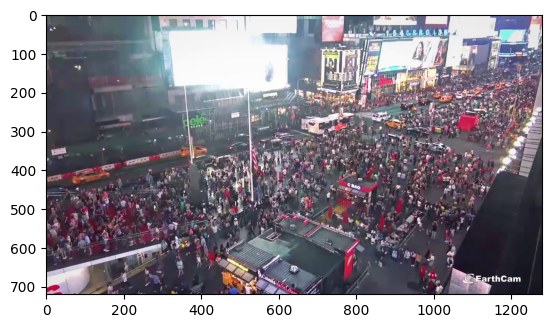

Predicted Count :  711


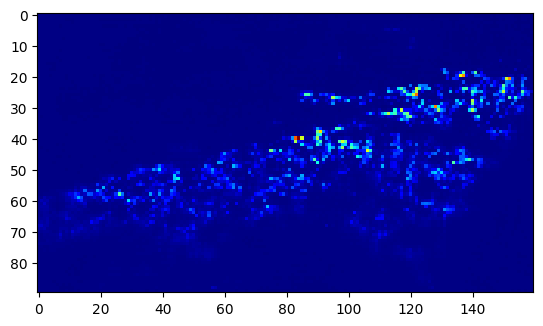

In [12]:
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

print("Original Image")
plt.imshow(frame_rgb)
plt.show()

img = transform(frame_rgb)
output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp, cmap = c.jet)
plt.show()

Transformed Heatmap


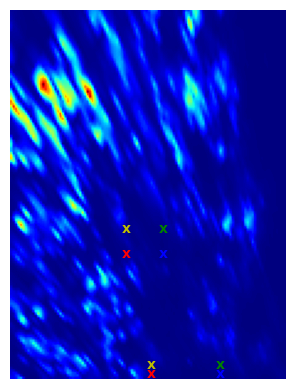

In [ ]:
# Annotated points on the original image
src = 0.125 * np.float32([
    [800, 300],  # top left
    [1150, 400],   # top right
    [1000, 680], # bottom right
    [340, 400], # bottom left
])

# Destination points for the bird's-eye view
# These points should form a rectangle in the new image
dst = np.float32([
    [0, 0],   # Top-left corner
    [88, 0], # Top-right corner
    [112,150], # Bottom-right corner
    [0, 150]  # Bottom-left corner
])

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Apply the perspective transformation
warped_frame = cv2.warpPerspective(temp, M, (112, 150))

print("Transformed Heatmap")
# Display the transformed frame
plt.imshow(warped_frame, cmap = c.jet)

# Bao stand
plt.annotate('x', (45, 90), c='y', fontweight=1000)
plt.annotate('x', (60, 90), c='g', fontweight=1000)
plt.annotate('x', (45, 100), c='r', fontweight=1000)
plt.annotate('x', (60, 100), c='b', fontweight=1000)

# Building at exit
plt.annotate('x', (55, 145), c='y', fontweight=1000)
plt.annotate('x', (83, 145), c='g', fontweight=1000)
plt.annotate('x', (55, 149), c='r', fontweight=1000)
plt.annotate('x', (83, 149), c='b', fontweight=1000)

plt.axis('off')
plt.show()

## Extract Density Maps from Video

In [ ]:
# discretize into (15x14 grids) such that there are 10x8 total grids. We perform a count within each grid at each 0.08 timestep.
# define state_history = (timesteps x (10x8))

def update_state_history(warped_frame, state_history):
    """
    Updates the state history array with the sum of pixel values in each 8x10 grid of the given warped_frame.

    Parameters:
    - warped_frame: A 150x112 NumPy array representing the density map.
    - state_history: A NumPy array where the first dimension is the time step, and the next two are the grid indices.

    Returns:
    - Updated state_history with the new counts added as the last time step.
    """
    # Ensure the warped_frame is the expected shape
    if warped_frame.shape != (150, 112):
        raise ValueError("warped_frame must be of shape (150, 112)")

    # Discretize the warped_frame into 14x15 grids (8x10 total grids)
    grid_counts = np.zeros((10, 8))
    for i in range(10):
        for j in range(8):
            # Extract the grid
            grid = warped_frame[i*15:(i+1)*15, j*14:(j+1)*14]

            # Sum the pixel values in the grid to get the count
            grid_count = np.sum(grid)

            # Update the grid_counts array
            grid_counts[i, j] = grid_count

    # Add the grid_counts to state_history as the latest time step
    if state_history is None:
        # If state_history is None, initialize it
        state_history = grid_counts[np.newaxis, :]
    else:
        # Append the grid_counts to state_history
        state_history = np.vstack([state_history, grid_counts[np.newaxis, :]])

    return state_history

In [ ]:
# Initialize state_history as None for the first time step
state_history = None
pred_counts = []

times = np.arange(17, 47, 0.08)

for desired_time in tqdm(times):
  cap = cv2.VideoCapture(video_path)

  # Get video frame rate
  fps = cap.get(cv2.CAP_PROP_FPS)

  # Calculate the frame number based on the desired time and frame rate
  frame_number = int(desired_time * fps)

  # Set the video position to the desired frame
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

  # Read the frame
  ret, frame = cap.read()

  # Convert the frame from BGR to RGB (for correct color rendering in matplotlib)
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  img = transform(frame_rgb)
  output = model(img.unsqueeze(0))
  pred_count = int(output.detach().cpu().sum().numpy())
  pred_counts.append(pred_count)
  print(f"Predicted Count at t = {desired_time}: {pred_count}")
  temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))

  # Annotated points on the original image
  src = 0.125 * np.float32([
      [800, 300],  # top left
      [1150, 400],   # top right
      [1000, 680], # bottom right
      [340, 400], # bottom left
  ])

  # Destination points for the bird's-eye view
  # These points should form a rectangle in the new image
  dst = np.float32([
      [0, 0],   # Top-left corner
      [88, 0], # Top-right corner
      [112,150], # Bottom-right corner
      [0, 150]  # Bottom-left corner
  ])

  # Compute the perspective transform matrix
  M = cv2.getPerspectiveTransform(src, dst)

  # Apply the perspective transformation
  warped_frame = cv2.warpPerspective(temp, M, (112, 150))

  state_history = update_state_history(warped_frame, state_history)

np.save('/content/drive/MyDrive/AC297R/Code/state_history.npy', state_history)
np.save('/content/drive/MyDrive/AC297R/Code/pred_counts.npy', np.array(pred_counts))
print("Successfully saved!")

  0%|          | 1/375 [00:15<1:37:53, 15.70s/it]

Predicted Count at t = 17.0: 351


  1%|          | 2/375 [00:31<1:36:16, 15.49s/it]

Predicted Count at t = 17.08: 361


  1%|          | 3/375 [00:46<1:34:40, 15.27s/it]

Predicted Count at t = 17.159999999999997: 398


  1%|          | 4/375 [01:01<1:35:37, 15.47s/it]

Predicted Count at t = 17.239999999999995: 463


  1%|▏         | 5/375 [01:18<1:38:11, 15.92s/it]

Predicted Count at t = 17.319999999999993: 462


  2%|▏         | 6/375 [01:33<1:36:23, 15.67s/it]

Predicted Count at t = 17.39999999999999: 487


  2%|▏         | 7/375 [01:49<1:36:34, 15.75s/it]

Predicted Count at t = 17.47999999999999: 446


  2%|▏         | 8/375 [02:04<1:35:00, 15.53s/it]

Predicted Count at t = 17.559999999999988: 423


  2%|▏         | 9/375 [02:19<1:33:13, 15.28s/it]

Predicted Count at t = 17.639999999999986: 416


  3%|▎         | 10/375 [02:34<1:32:36, 15.22s/it]

Predicted Count at t = 17.719999999999985: 389


  3%|▎         | 11/375 [02:49<1:31:36, 15.10s/it]

Predicted Count at t = 17.799999999999983: 416


  3%|▎         | 12/375 [03:04<1:31:39, 15.15s/it]

Predicted Count at t = 17.87999999999998: 402


  3%|▎         | 13/375 [03:19<1:30:46, 15.05s/it]

Predicted Count at t = 17.95999999999998: 453


  4%|▎         | 14/375 [03:34<1:31:00, 15.12s/it]

Predicted Count at t = 18.039999999999978: 402


  4%|▍         | 15/375 [03:48<1:29:08, 14.86s/it]

Predicted Count at t = 18.119999999999976: 399


  4%|▍         | 16/375 [04:03<1:28:50, 14.85s/it]

Predicted Count at t = 18.199999999999974: 407


  5%|▍         | 17/375 [04:18<1:28:36, 14.85s/it]

Predicted Count at t = 18.279999999999973: 433


  5%|▍         | 18/375 [04:33<1:29:07, 14.98s/it]

Predicted Count at t = 18.35999999999997: 391


  5%|▌         | 19/375 [04:48<1:27:28, 14.74s/it]

Predicted Count at t = 18.43999999999997: 383


  5%|▌         | 20/375 [05:03<1:27:33, 14.80s/it]

Predicted Count at t = 18.519999999999968: 354


  6%|▌         | 21/375 [05:17<1:26:22, 14.64s/it]

Predicted Count at t = 18.599999999999966: 409


  6%|▌         | 22/375 [05:32<1:26:45, 14.75s/it]

Predicted Count at t = 18.679999999999964: 401


  6%|▌         | 23/375 [05:46<1:25:27, 14.57s/it]

Predicted Count at t = 18.759999999999962: 396


  6%|▋         | 24/375 [06:01<1:25:31, 14.62s/it]

Predicted Count at t = 18.83999999999996: 442


  7%|▋         | 25/375 [06:15<1:24:19, 14.46s/it]

Predicted Count at t = 18.91999999999996: 416


  7%|▋         | 26/375 [06:30<1:24:36, 14.55s/it]

Predicted Count at t = 18.999999999999957: 464


  7%|▋         | 27/375 [06:44<1:24:00, 14.48s/it]

Predicted Count at t = 19.079999999999956: 430


  7%|▋         | 28/375 [06:59<1:24:01, 14.53s/it]

Predicted Count at t = 19.159999999999954: 451


  8%|▊         | 29/375 [07:13<1:23:06, 14.41s/it]

Predicted Count at t = 19.239999999999952: 303


  8%|▊         | 30/375 [07:27<1:23:28, 14.52s/it]

Predicted Count at t = 19.31999999999995: 286


  8%|▊         | 31/375 [07:42<1:23:23, 14.55s/it]

Predicted Count at t = 19.39999999999995: 262


  9%|▊         | 32/375 [07:57<1:24:23, 14.76s/it]

Predicted Count at t = 19.479999999999947: 296


  9%|▉         | 33/375 [08:13<1:25:37, 15.02s/it]

Predicted Count at t = 19.559999999999945: 242


  9%|▉         | 34/375 [08:31<1:30:17, 15.89s/it]

Predicted Count at t = 19.639999999999944: 283


  9%|▉         | 35/375 [08:46<1:28:45, 15.66s/it]

Predicted Count at t = 19.719999999999942: 250


 10%|▉         | 36/375 [09:01<1:27:52, 15.55s/it]

Predicted Count at t = 19.79999999999994: 248


 10%|▉         | 37/375 [09:17<1:27:08, 15.47s/it]

Predicted Count at t = 19.87999999999994: 266


 10%|█         | 38/375 [09:31<1:25:17, 15.18s/it]

Predicted Count at t = 19.959999999999937: 281


 10%|█         | 39/375 [09:46<1:24:37, 15.11s/it]

Predicted Count at t = 20.039999999999935: 306


 11%|█         | 40/375 [10:01<1:23:30, 14.96s/it]

Predicted Count at t = 20.119999999999933: 354


 11%|█         | 41/375 [10:17<1:25:16, 15.32s/it]

Predicted Count at t = 20.199999999999932: 307


 11%|█         | 42/375 [10:31<1:23:58, 15.13s/it]

Predicted Count at t = 20.27999999999993: 324


 11%|█▏        | 43/375 [10:46<1:23:04, 15.01s/it]

Predicted Count at t = 20.35999999999993: 337


 12%|█▏        | 44/375 [11:01<1:22:09, 14.89s/it]

Predicted Count at t = 20.439999999999927: 329


 12%|█▏        | 45/375 [11:15<1:21:19, 14.79s/it]

Predicted Count at t = 20.519999999999925: 311


 12%|█▏        | 46/375 [11:30<1:20:58, 14.77s/it]

Predicted Count at t = 20.599999999999923: 357


 13%|█▎        | 47/375 [11:45<1:20:19, 14.69s/it]

Predicted Count at t = 20.67999999999992: 393


 13%|█▎        | 48/375 [11:59<1:19:56, 14.67s/it]

Predicted Count at t = 20.75999999999992: 379


 13%|█▎        | 49/375 [12:14<1:19:41, 14.67s/it]

Predicted Count at t = 20.839999999999918: 459


 13%|█▎        | 50/375 [12:28<1:19:07, 14.61s/it]

Predicted Count at t = 20.919999999999916: 386


 14%|█▎        | 51/375 [12:43<1:18:37, 14.56s/it]

Predicted Count at t = 20.999999999999915: 477


 14%|█▍        | 52/375 [12:57<1:17:55, 14.48s/it]

Predicted Count at t = 21.079999999999913: 423


 14%|█▍        | 53/375 [13:12<1:18:59, 14.72s/it]

Predicted Count at t = 21.15999999999991: 459


 14%|█▍        | 54/375 [13:27<1:18:22, 14.65s/it]

Predicted Count at t = 21.23999999999991: 408


 15%|█▍        | 55/375 [13:42<1:19:44, 14.95s/it]

Predicted Count at t = 21.319999999999908: 395


 15%|█▍        | 56/375 [13:57<1:18:45, 14.81s/it]

Predicted Count at t = 21.399999999999906: 402


 15%|█▌        | 57/375 [14:12<1:18:58, 14.90s/it]

Predicted Count at t = 21.479999999999905: 388


 15%|█▌        | 58/375 [14:27<1:18:02, 14.77s/it]

Predicted Count at t = 21.559999999999903: 410


 16%|█▌        | 59/375 [14:41<1:17:21, 14.69s/it]

Predicted Count at t = 21.6399999999999: 407


 16%|█▌        | 60/375 [14:56<1:17:11, 14.70s/it]

Predicted Count at t = 21.7199999999999: 423


 16%|█▋        | 61/375 [15:10<1:16:30, 14.62s/it]

Predicted Count at t = 21.799999999999898: 402


 17%|█▋        | 62/375 [15:25<1:16:36, 14.68s/it]

Predicted Count at t = 21.879999999999896: 383


 17%|█▋        | 63/375 [15:39<1:15:25, 14.51s/it]

Predicted Count at t = 21.959999999999894: 350


 17%|█▋        | 64/375 [15:53<1:14:32, 14.38s/it]

Predicted Count at t = 22.039999999999893: 381


 17%|█▋        | 65/375 [16:07<1:13:35, 14.24s/it]

Predicted Count at t = 22.11999999999989: 390


 18%|█▊        | 66/375 [16:21<1:13:01, 14.18s/it]

Predicted Count at t = 22.19999999999989: 436


 18%|█▊        | 67/375 [16:35<1:12:24, 14.10s/it]

Predicted Count at t = 22.279999999999887: 252


 18%|█▊        | 68/375 [16:49<1:11:52, 14.05s/it]

Predicted Count at t = 22.359999999999886: 252


 18%|█▊        | 69/375 [17:03<1:11:24, 14.00s/it]

Predicted Count at t = 22.439999999999884: 245


 19%|█▊        | 70/375 [17:17<1:11:33, 14.08s/it]

Predicted Count at t = 22.519999999999882: 275


 19%|█▉        | 71/375 [17:31<1:11:27, 14.10s/it]

Predicted Count at t = 22.59999999999988: 285


 19%|█▉        | 72/375 [17:47<1:12:56, 14.44s/it]

Predicted Count at t = 22.67999999999988: 243


 19%|█▉        | 73/375 [18:01<1:12:34, 14.42s/it]

Predicted Count at t = 22.759999999999877: 275


 20%|█▉        | 74/375 [18:16<1:12:53, 14.53s/it]

Predicted Count at t = 22.839999999999876: 275


 20%|██        | 75/375 [18:33<1:17:15, 15.45s/it]

Predicted Count at t = 22.919999999999874: 296


 20%|██        | 76/375 [18:48<1:16:21, 15.32s/it]

Predicted Count at t = 22.999999999999872: 326


 21%|██        | 77/375 [19:03<1:14:33, 15.01s/it]

Predicted Count at t = 23.07999999999987: 320


 21%|██        | 78/375 [19:17<1:13:54, 14.93s/it]

Predicted Count at t = 23.15999999999987: 351


 21%|██        | 79/375 [19:32<1:13:33, 14.91s/it]

Predicted Count at t = 23.239999999999867: 351


 21%|██▏       | 80/375 [19:48<1:13:55, 15.04s/it]

Predicted Count at t = 23.319999999999865: 343


 22%|██▏       | 81/375 [20:02<1:12:38, 14.83s/it]

Predicted Count at t = 23.399999999999864: 350


 22%|██▏       | 82/375 [20:18<1:14:12, 15.20s/it]

Predicted Count at t = 23.479999999999862: 323


 22%|██▏       | 83/375 [20:33<1:13:08, 15.03s/it]

Predicted Count at t = 23.55999999999986: 359


 22%|██▏       | 84/375 [20:48<1:13:37, 15.18s/it]

Predicted Count at t = 23.63999999999986: 306


 23%|██▎       | 85/375 [21:03<1:12:26, 14.99s/it]

Predicted Count at t = 23.719999999999857: 345


 23%|██▎       | 86/375 [21:18<1:12:39, 15.09s/it]

Predicted Count at t = 23.799999999999855: 363


 23%|██▎       | 87/375 [21:32<1:11:26, 14.88s/it]

Predicted Count at t = 23.879999999999853: 411


 23%|██▎       | 88/375 [21:47<1:11:27, 14.94s/it]

Predicted Count at t = 23.95999999999985: 355


 24%|██▎       | 89/375 [22:02<1:10:15, 14.74s/it]

Predicted Count at t = 24.03999999999985: 324


 24%|██▍       | 90/375 [22:17<1:10:14, 14.79s/it]

Predicted Count at t = 24.11999999999985: 372


 24%|██▍       | 91/375 [22:31<1:09:19, 14.65s/it]

Predicted Count at t = 24.199999999999847: 379


 25%|██▍       | 92/375 [22:46<1:09:25, 14.72s/it]

Predicted Count at t = 24.279999999999845: 435


 25%|██▍       | 93/375 [23:00<1:08:51, 14.65s/it]

Predicted Count at t = 24.359999999999843: 361


 25%|██▌       | 94/375 [23:16<1:10:08, 14.98s/it]

Predicted Count at t = 24.43999999999984: 376


 25%|██▌       | 95/375 [23:31<1:10:14, 15.05s/it]

Predicted Count at t = 24.51999999999984: 362


 26%|██▌       | 96/375 [23:46<1:10:05, 15.07s/it]

Predicted Count at t = 24.599999999999838: 394


 26%|██▌       | 97/375 [24:01<1:09:20, 14.96s/it]

Predicted Count at t = 24.679999999999836: 343


 26%|██▌       | 98/375 [24:16<1:08:46, 14.90s/it]

Predicted Count at t = 24.759999999999835: 394


 26%|██▋       | 99/375 [24:30<1:07:40, 14.71s/it]

Predicted Count at t = 24.839999999999833: 340


 27%|██▋       | 100/375 [24:45<1:07:33, 14.74s/it]

Predicted Count at t = 24.91999999999983: 387


 27%|██▋       | 101/375 [24:59<1:06:51, 14.64s/it]

Predicted Count at t = 24.99999999999983: 400


 27%|██▋       | 102/375 [25:14<1:06:43, 14.67s/it]

Predicted Count at t = 25.079999999999828: 388


 27%|██▋       | 103/375 [25:28<1:05:47, 14.51s/it]

Predicted Count at t = 25.159999999999826: 454


 28%|██▊       | 104/375 [25:43<1:06:17, 14.68s/it]

Predicted Count at t = 25.239999999999824: 248


 28%|██▊       | 105/375 [25:58<1:05:25, 14.54s/it]

Predicted Count at t = 25.319999999999823: 232


 28%|██▊       | 106/375 [26:13<1:05:56, 14.71s/it]

Predicted Count at t = 25.39999999999982: 202


 29%|██▊       | 107/375 [26:27<1:05:22, 14.64s/it]

Predicted Count at t = 25.47999999999982: 214


 29%|██▉       | 108/375 [26:43<1:06:13, 14.88s/it]

Predicted Count at t = 25.559999999999818: 182


 29%|██▉       | 109/375 [26:57<1:05:28, 14.77s/it]

Predicted Count at t = 25.639999999999816: 209


 29%|██▉       | 110/375 [27:12<1:05:23, 14.81s/it]

Predicted Count at t = 25.719999999999814: 191


 30%|██▉       | 111/375 [27:26<1:04:32, 14.67s/it]

Predicted Count at t = 25.799999999999812: 190


 30%|██▉       | 112/375 [27:41<1:04:26, 14.70s/it]

Predicted Count at t = 25.87999999999981: 178


 30%|███       | 113/375 [27:56<1:04:06, 14.68s/it]

Predicted Count at t = 25.95999999999981: 175


 30%|███       | 114/375 [28:10<1:03:46, 14.66s/it]

Predicted Count at t = 26.039999999999807: 195


 31%|███       | 115/375 [28:25<1:03:07, 14.57s/it]

Predicted Count at t = 26.119999999999806: 186


 31%|███       | 116/375 [28:42<1:06:55, 15.50s/it]

Predicted Count at t = 26.199999999999804: 193


 31%|███       | 117/375 [28:57<1:05:27, 15.22s/it]

Predicted Count at t = 26.279999999999802: 188


 31%|███▏      | 118/375 [29:11<1:04:15, 15.00s/it]

Predicted Count at t = 26.3599999999998: 182


 32%|███▏      | 119/375 [29:26<1:03:13, 14.82s/it]

Predicted Count at t = 26.4399999999998: 196


 32%|███▏      | 120/375 [29:41<1:03:02, 14.83s/it]

Predicted Count at t = 26.519999999999797: 211


 32%|███▏      | 121/375 [29:56<1:03:12, 14.93s/it]

Predicted Count at t = 26.599999999999795: 250


 33%|███▎      | 122/375 [30:11<1:03:36, 15.09s/it]

Predicted Count at t = 26.679999999999794: 258


 33%|███▎      | 123/375 [30:26<1:02:48, 14.96s/it]

Predicted Count at t = 26.759999999999792: 264


 33%|███▎      | 124/375 [30:41<1:02:12, 14.87s/it]

Predicted Count at t = 26.83999999999979: 298


 33%|███▎      | 125/375 [30:55<1:01:33, 14.77s/it]

Predicted Count at t = 26.91999999999979: 288


 34%|███▎      | 126/375 [31:10<1:01:07, 14.73s/it]

Predicted Count at t = 26.999999999999787: 311


 34%|███▍      | 127/375 [31:24<1:00:47, 14.71s/it]

Predicted Count at t = 27.079999999999785: 309


 34%|███▍      | 128/375 [31:39<1:00:21, 14.66s/it]

Predicted Count at t = 27.159999999999783: 293


 34%|███▍      | 129/375 [31:53<59:04, 14.41s/it]  

Predicted Count at t = 27.23999999999978: 304


 35%|███▍      | 130/375 [32:07<58:19, 14.28s/it]

Predicted Count at t = 27.31999999999978: 292


 35%|███▍      | 131/375 [32:21<57:40, 14.18s/it]

Predicted Count at t = 27.39999999999978: 255


 35%|███▌      | 132/375 [32:35<57:08, 14.11s/it]

Predicted Count at t = 27.479999999999777: 251


 35%|███▌      | 133/375 [32:49<56:34, 14.03s/it]

Predicted Count at t = 27.559999999999775: 232


 36%|███▌      | 134/375 [33:03<56:23, 14.04s/it]

Predicted Count at t = 27.639999999999773: 246


 36%|███▌      | 135/375 [33:16<55:48, 13.95s/it]

Predicted Count at t = 27.71999999999977: 212


 36%|███▋      | 136/375 [33:30<55:25, 13.91s/it]

Predicted Count at t = 27.79999999999977: 229


 37%|███▋      | 137/375 [33:44<55:07, 13.90s/it]

Predicted Count at t = 27.879999999999768: 210


 37%|███▋      | 138/375 [33:58<54:52, 13.89s/it]

Predicted Count at t = 27.959999999999766: 211


 37%|███▋      | 139/375 [34:12<54:46, 13.93s/it]

Predicted Count at t = 28.039999999999765: 219


 37%|███▋      | 140/375 [34:26<54:14, 13.85s/it]

Predicted Count at t = 28.119999999999763: 213


 38%|███▊      | 141/375 [34:40<54:22, 13.94s/it]

Predicted Count at t = 28.19999999999976: 217


 38%|███▊      | 142/375 [34:54<54:23, 14.01s/it]

Predicted Count at t = 28.27999999999976: 124


 38%|███▊      | 143/375 [35:08<53:49, 13.92s/it]

Predicted Count at t = 28.359999999999758: 114


 38%|███▊      | 144/375 [35:22<54:15, 14.09s/it]

Predicted Count at t = 28.439999999999756: 106


 39%|███▊      | 145/375 [35:36<54:09, 14.13s/it]

Predicted Count at t = 28.519999999999754: 108


 39%|███▉      | 146/375 [35:51<54:16, 14.22s/it]

Predicted Count at t = 28.599999999999753: 114


 39%|███▉      | 147/375 [36:05<54:07, 14.25s/it]

Predicted Count at t = 28.67999999999975: 113


 39%|███▉      | 148/375 [36:19<53:48, 14.22s/it]

Predicted Count at t = 28.75999999999975: 108


 40%|███▉      | 149/375 [36:34<53:40, 14.25s/it]

Predicted Count at t = 28.839999999999748: 107


 40%|████      | 150/375 [36:48<53:33, 14.28s/it]

Predicted Count at t = 28.919999999999746: 112


 40%|████      | 151/375 [37:02<53:06, 14.22s/it]

Predicted Count at t = 28.999999999999744: 122


 41%|████      | 152/375 [37:16<52:45, 14.20s/it]

Predicted Count at t = 29.079999999999742: 117


 41%|████      | 153/375 [37:30<52:39, 14.23s/it]

Predicted Count at t = 29.15999999999974: 120


 41%|████      | 154/375 [37:45<52:24, 14.23s/it]

Predicted Count at t = 29.23999999999974: 126


 41%|████▏     | 155/375 [37:59<52:08, 14.22s/it]

Predicted Count at t = 29.319999999999737: 141


 42%|████▏     | 156/375 [38:13<52:17, 14.33s/it]

Predicted Count at t = 29.399999999999736: 146


 42%|████▏     | 157/375 [38:28<51:54, 14.29s/it]

Predicted Count at t = 29.479999999999734: 157


 42%|████▏     | 158/375 [38:42<51:13, 14.16s/it]

Predicted Count at t = 29.559999999999732: 157


 42%|████▏     | 159/375 [38:56<51:08, 14.21s/it]

Predicted Count at t = 29.63999999999973: 168


 43%|████▎     | 160/375 [39:10<50:27, 14.08s/it]

Predicted Count at t = 29.71999999999973: 187


 43%|████▎     | 161/375 [39:24<50:35, 14.18s/it]

Predicted Count at t = 29.799999999999727: 183


 43%|████▎     | 162/375 [39:38<50:11, 14.14s/it]

Predicted Count at t = 29.879999999999725: 175


 43%|████▎     | 163/375 [39:52<50:02, 14.16s/it]

Predicted Count at t = 29.959999999999724: 195


 44%|████▎     | 164/375 [40:06<49:41, 14.13s/it]

Predicted Count at t = 30.039999999999722: 206


 44%|████▍     | 165/375 [40:21<49:31, 14.15s/it]

Predicted Count at t = 30.11999999999972: 228


 44%|████▍     | 166/375 [40:35<49:24, 14.18s/it]

Predicted Count at t = 30.19999999999972: 206


 45%|████▍     | 167/375 [40:50<49:53, 14.39s/it]

Predicted Count at t = 30.279999999999717: 201


 45%|████▍     | 168/375 [41:04<50:01, 14.50s/it]

Predicted Count at t = 30.359999999999715: 242


 45%|████▌     | 169/375 [41:19<49:42, 14.48s/it]

Predicted Count at t = 30.439999999999714: 262


 45%|████▌     | 170/375 [41:33<49:07, 14.38s/it]

Predicted Count at t = 30.519999999999712: 256


 46%|████▌     | 171/375 [41:47<48:50, 14.37s/it]

Predicted Count at t = 30.59999999999971: 267


 46%|████▌     | 172/375 [42:02<48:33, 14.35s/it]

Predicted Count at t = 30.67999999999971: 257


 46%|████▌     | 173/375 [42:16<48:33, 14.42s/it]

Predicted Count at t = 30.759999999999707: 311


 46%|████▋     | 174/375 [42:31<48:15, 14.41s/it]

Predicted Count at t = 30.839999999999705: 269


 47%|████▋     | 175/375 [42:45<48:11, 14.46s/it]

Predicted Count at t = 30.919999999999703: 295


 47%|████▋     | 176/375 [43:00<47:51, 14.43s/it]

Predicted Count at t = 30.9999999999997: 260


 47%|████▋     | 177/375 [43:14<47:41, 14.45s/it]

Predicted Count at t = 31.0799999999997: 274


 47%|████▋     | 178/375 [43:29<47:27, 14.46s/it]

Predicted Count at t = 31.159999999999698: 241


 48%|████▊     | 179/375 [43:43<47:18, 14.48s/it]

Predicted Count at t = 31.239999999999696: 262


 48%|████▊     | 180/375 [43:58<47:19, 14.56s/it]

Predicted Count at t = 31.319999999999695: 217


 48%|████▊     | 181/375 [44:12<47:00, 14.54s/it]

Predicted Count at t = 31.399999999999693: 241


 49%|████▊     | 182/375 [44:28<47:29, 14.77s/it]

Predicted Count at t = 31.47999999999969: 226


 49%|████▉     | 183/375 [44:43<47:36, 14.88s/it]

Predicted Count at t = 31.55999999999969: 250


 49%|████▉     | 184/375 [44:58<47:28, 14.91s/it]

Predicted Count at t = 31.639999999999688: 164


 49%|████▉     | 185/375 [45:13<47:15, 14.93s/it]

Predicted Count at t = 31.719999999999686: 156


 50%|████▉     | 186/375 [45:27<46:42, 14.83s/it]

Predicted Count at t = 31.799999999999685: 137


 50%|████▉     | 187/375 [45:42<46:42, 14.91s/it]

Predicted Count at t = 31.879999999999683: 142


 50%|█████     | 188/375 [45:57<46:05, 14.79s/it]

Predicted Count at t = 31.95999999999968: 135


 50%|█████     | 189/375 [46:12<46:08, 14.89s/it]

Predicted Count at t = 32.03999999999968: 154


 51%|█████     | 190/375 [46:26<45:08, 14.64s/it]

Predicted Count at t = 32.11999999999968: 143


 51%|█████     | 191/375 [46:41<45:09, 14.72s/it]

Predicted Count at t = 32.199999999999676: 159


 51%|█████     | 192/375 [46:56<44:44, 14.67s/it]

Predicted Count at t = 32.279999999999674: 153


 51%|█████▏    | 193/375 [47:11<44:54, 14.81s/it]

Predicted Count at t = 32.35999999999967: 167


 52%|█████▏    | 194/375 [47:26<45:05, 14.95s/it]

Predicted Count at t = 32.43999999999967: 157


 52%|█████▏    | 195/375 [47:42<45:29, 15.16s/it]

Predicted Count at t = 32.51999999999967: 167


 52%|█████▏    | 196/375 [47:56<44:14, 14.83s/it]

Predicted Count at t = 32.59999999999967: 167


 53%|█████▎    | 197/375 [48:10<43:45, 14.75s/it]

Predicted Count at t = 32.679999999999666: 175


 53%|█████▎    | 198/375 [48:24<42:50, 14.52s/it]

Predicted Count at t = 32.759999999999664: 180


 53%|█████▎    | 199/375 [48:39<42:31, 14.50s/it]

Predicted Count at t = 32.83999999999966: 219


 53%|█████▎    | 200/375 [48:52<41:38, 14.28s/it]

Predicted Count at t = 32.91999999999966: 204


 54%|█████▎    | 201/375 [49:07<41:31, 14.32s/it]

Predicted Count at t = 32.99999999999966: 221


 54%|█████▍    | 202/375 [49:21<41:02, 14.23s/it]

Predicted Count at t = 33.07999999999966: 194


 54%|█████▍    | 203/375 [49:35<41:06, 14.34s/it]

Predicted Count at t = 33.159999999999656: 223


 54%|█████▍    | 204/375 [49:49<40:27, 14.19s/it]

Predicted Count at t = 33.239999999999654: 211


 55%|█████▍    | 205/375 [50:04<40:36, 14.33s/it]

Predicted Count at t = 33.31999999999965: 216


 55%|█████▍    | 206/375 [50:18<40:06, 14.24s/it]

Predicted Count at t = 33.39999999999965: 196


 55%|█████▌    | 207/375 [50:32<39:45, 14.20s/it]

Predicted Count at t = 33.47999999999965: 207


 55%|█████▌    | 208/375 [50:46<39:10, 14.08s/it]

Predicted Count at t = 33.55999999999965: 225


 56%|█████▌    | 209/375 [51:00<39:10, 14.16s/it]

Predicted Count at t = 33.639999999999645: 244


 56%|█████▌    | 210/375 [51:14<38:24, 13.97s/it]

Predicted Count at t = 33.719999999999644: 242


 56%|█████▋    | 211/375 [51:28<38:15, 14.00s/it]

Predicted Count at t = 33.79999999999964: 258


 57%|█████▋    | 212/375 [51:42<37:52, 13.94s/it]

Predicted Count at t = 33.87999999999964: 269


 57%|█████▋    | 213/375 [51:56<37:38, 13.94s/it]

Predicted Count at t = 33.95999999999964: 241


 57%|█████▋    | 214/375 [52:10<37:30, 13.98s/it]

Predicted Count at t = 34.03999999999964: 281


 57%|█████▋    | 215/375 [52:24<37:35, 14.09s/it]

Predicted Count at t = 34.119999999999635: 265


 58%|█████▊    | 216/375 [52:38<37:25, 14.12s/it]

Predicted Count at t = 34.19999999999963: 324


 58%|█████▊    | 217/375 [52:53<37:21, 14.19s/it]

Predicted Count at t = 34.27999999999963: 280


 58%|█████▊    | 218/375 [53:08<37:52, 14.47s/it]

Predicted Count at t = 34.35999999999963: 301


 58%|█████▊    | 219/375 [53:22<37:23, 14.38s/it]

Predicted Count at t = 34.43999999999963: 307


 59%|█████▊    | 220/375 [53:36<37:16, 14.43s/it]

Predicted Count at t = 34.51999999999963: 255


 59%|█████▉    | 221/375 [53:51<36:57, 14.40s/it]

Predicted Count at t = 34.599999999999625: 271


 59%|█████▉    | 222/375 [54:05<36:37, 14.36s/it]

Predicted Count at t = 34.67999999999962: 160


 59%|█████▉    | 223/375 [54:19<36:19, 14.34s/it]

Predicted Count at t = 34.75999999999962: 153


 60%|█████▉    | 224/375 [54:34<36:05, 14.34s/it]

Predicted Count at t = 34.83999999999962: 139


 60%|██████    | 225/375 [54:48<35:41, 14.28s/it]

Predicted Count at t = 34.91999999999962: 153


 60%|██████    | 226/375 [55:02<35:24, 14.26s/it]

Predicted Count at t = 34.999999999999616: 145


 61%|██████    | 227/375 [55:16<35:08, 14.25s/it]

Predicted Count at t = 35.079999999999615: 184


 61%|██████    | 228/375 [55:30<34:52, 14.24s/it]

Predicted Count at t = 35.15999999999961: 161


 61%|██████    | 229/375 [55:45<34:43, 14.27s/it]

Predicted Count at t = 35.23999999999961: 177


 61%|██████▏   | 230/375 [55:59<34:23, 14.23s/it]

Predicted Count at t = 35.31999999999961: 170


 62%|██████▏   | 231/375 [56:13<34:12, 14.25s/it]

Predicted Count at t = 35.39999999999961: 181


 62%|██████▏   | 232/375 [56:27<33:54, 14.23s/it]

Predicted Count at t = 35.479999999999606: 177


 62%|██████▏   | 233/375 [56:42<33:45, 14.26s/it]

Predicted Count at t = 35.559999999999604: 202


 62%|██████▏   | 234/375 [56:56<33:41, 14.34s/it]

Predicted Count at t = 35.6399999999996: 206


 63%|██████▎   | 235/375 [57:11<33:45, 14.47s/it]

Predicted Count at t = 35.7199999999996: 221


 63%|██████▎   | 236/375 [57:25<33:24, 14.42s/it]

Predicted Count at t = 35.7999999999996: 190


 63%|██████▎   | 237/375 [57:40<33:22, 14.51s/it]

Predicted Count at t = 35.8799999999996: 205


 63%|██████▎   | 238/375 [57:54<33:00, 14.46s/it]

Predicted Count at t = 35.959999999999596: 185


 64%|██████▎   | 239/375 [58:09<32:47, 14.46s/it]

Predicted Count at t = 36.039999999999594: 204


 64%|██████▍   | 240/375 [58:23<32:31, 14.46s/it]

Predicted Count at t = 36.11999999999959: 230


 64%|██████▍   | 241/375 [58:40<33:31, 15.01s/it]

Predicted Count at t = 36.19999999999959: 234


 65%|██████▍   | 242/375 [58:55<33:18, 15.03s/it]

Predicted Count at t = 36.27999999999959: 273


 65%|██████▍   | 243/375 [59:10<33:03, 15.03s/it]

Predicted Count at t = 36.35999999999959: 257


 65%|██████▌   | 244/375 [59:24<32:26, 14.86s/it]

Predicted Count at t = 36.439999999999586: 279


 65%|██████▌   | 245/375 [59:38<31:48, 14.68s/it]

Predicted Count at t = 36.519999999999584: 246


 66%|██████▌   | 246/375 [59:53<31:13, 14.53s/it]

Predicted Count at t = 36.59999999999958: 248


 66%|██████▌   | 247/375 [1:00:07<30:49, 14.45s/it]

Predicted Count at t = 36.67999999999958: 239


 66%|██████▌   | 248/375 [1:00:22<30:51, 14.58s/it]

Predicted Count at t = 36.75999999999958: 237


 66%|██████▋   | 249/375 [1:00:36<30:42, 14.62s/it]

Predicted Count at t = 36.83999999999958: 246


 67%|██████▋   | 250/375 [1:00:51<30:45, 14.76s/it]

Predicted Count at t = 36.919999999999575: 251


 67%|██████▋   | 251/375 [1:01:06<30:29, 14.75s/it]

Predicted Count at t = 36.999999999999574: 233


 67%|██████▋   | 252/375 [1:01:21<30:07, 14.70s/it]

Predicted Count at t = 37.07999999999957: 243


 67%|██████▋   | 253/375 [1:01:36<29:55, 14.72s/it]

Predicted Count at t = 37.15999999999957: 246


 68%|██████▊   | 254/375 [1:01:50<29:34, 14.67s/it]

Predicted Count at t = 37.23999999999957: 253


 68%|██████▊   | 255/375 [1:02:05<29:20, 14.67s/it]

Predicted Count at t = 37.31999999999957: 239


 68%|██████▊   | 256/375 [1:02:19<29:00, 14.63s/it]

Predicted Count at t = 37.399999999999565: 274


 69%|██████▊   | 257/375 [1:02:34<28:36, 14.55s/it]

Predicted Count at t = 37.47999999999956: 232


 69%|██████▉   | 258/375 [1:02:48<28:23, 14.56s/it]

Predicted Count at t = 37.55999999999956: 268


 69%|██████▉   | 259/375 [1:03:03<28:05, 14.53s/it]

Predicted Count at t = 37.63999999999956: 211


 69%|██████▉   | 260/375 [1:03:17<27:54, 14.56s/it]

Predicted Count at t = 37.71999999999956: 133


 70%|██████▉   | 261/375 [1:03:32<27:54, 14.69s/it]

Predicted Count at t = 37.79999999999956: 136


 70%|██████▉   | 262/375 [1:03:48<28:16, 15.01s/it]

Predicted Count at t = 37.879999999999555: 125


 70%|███████   | 263/375 [1:04:02<27:31, 14.74s/it]

Predicted Count at t = 37.95999999999955: 130


 70%|███████   | 264/375 [1:04:17<27:08, 14.67s/it]

Predicted Count at t = 38.03999999999955: 135


 71%|███████   | 265/375 [1:04:31<26:45, 14.60s/it]

Predicted Count at t = 38.11999999999955: 139


 71%|███████   | 266/375 [1:04:45<26:12, 14.42s/it]

Predicted Count at t = 38.19999999999955: 151


 71%|███████   | 267/375 [1:05:00<26:10, 14.54s/it]

Predicted Count at t = 38.279999999999546: 154


 71%|███████▏  | 268/375 [1:05:14<25:37, 14.37s/it]

Predicted Count at t = 38.359999999999545: 160


 72%|███████▏  | 269/375 [1:05:29<25:35, 14.49s/it]

Predicted Count at t = 38.43999999999954: 159


 72%|███████▏  | 270/375 [1:05:43<25:07, 14.35s/it]

Predicted Count at t = 38.51999999999954: 168


 72%|███████▏  | 271/375 [1:05:57<25:03, 14.45s/it]

Predicted Count at t = 38.59999999999954: 162


 73%|███████▎  | 272/375 [1:06:11<24:35, 14.33s/it]

Predicted Count at t = 38.67999999999954: 176


 73%|███████▎  | 273/375 [1:06:26<24:29, 14.40s/it]

Predicted Count at t = 38.759999999999536: 188


 73%|███████▎  | 274/375 [1:06:40<24:02, 14.28s/it]

Predicted Count at t = 38.839999999999534: 176


 73%|███████▎  | 275/375 [1:06:54<23:51, 14.32s/it]

Predicted Count at t = 38.91999999999953: 183


 74%|███████▎  | 276/375 [1:07:09<23:30, 14.25s/it]

Predicted Count at t = 38.99999999999953: 192


 74%|███████▍  | 277/375 [1:07:24<23:47, 14.56s/it]

Predicted Count at t = 39.07999999999953: 203


 74%|███████▍  | 278/375 [1:07:38<23:26, 14.50s/it]

Predicted Count at t = 39.15999999999953: 192


 74%|███████▍  | 279/375 [1:07:53<23:23, 14.62s/it]

Predicted Count at t = 39.239999999999526: 198


 75%|███████▍  | 280/375 [1:08:07<22:55, 14.48s/it]

Predicted Count at t = 39.319999999999524: 186


 75%|███████▍  | 281/375 [1:08:22<22:47, 14.54s/it]

Predicted Count at t = 39.39999999999952: 194


 75%|███████▌  | 282/375 [1:08:36<22:21, 14.43s/it]

Predicted Count at t = 39.47999999999952: 202


 75%|███████▌  | 283/375 [1:08:50<22:05, 14.41s/it]

Predicted Count at t = 39.55999999999952: 207


 76%|███████▌  | 284/375 [1:09:04<21:40, 14.29s/it]

Predicted Count at t = 39.63999999999952: 223


 76%|███████▌  | 285/375 [1:09:19<21:28, 14.32s/it]

Predicted Count at t = 39.719999999999516: 233


 76%|███████▋  | 286/375 [1:09:33<21:05, 14.22s/it]

Predicted Count at t = 39.799999999999514: 232


 77%|███████▋  | 287/375 [1:09:47<20:54, 14.26s/it]

Predicted Count at t = 39.87999999999951: 233


 77%|███████▋  | 288/375 [1:10:01<20:33, 14.17s/it]

Predicted Count at t = 39.95999999999951: 231


 77%|███████▋  | 289/375 [1:10:16<20:24, 14.24s/it]

Predicted Count at t = 40.03999999999951: 227


 77%|███████▋  | 290/375 [1:10:30<20:08, 14.21s/it]

Predicted Count at t = 40.11999999999951: 216


 78%|███████▊  | 291/375 [1:10:44<19:56, 14.25s/it]

Predicted Count at t = 40.199999999999505: 228


 78%|███████▊  | 292/375 [1:10:58<19:34, 14.15s/it]

Predicted Count at t = 40.279999999999504: 230


 78%|███████▊  | 293/375 [1:11:13<19:40, 14.40s/it]

Predicted Count at t = 40.3599999999995: 221


 78%|███████▊  | 294/375 [1:11:27<19:28, 14.43s/it]

Predicted Count at t = 40.4399999999995: 236


 79%|███████▊  | 295/375 [1:11:43<19:32, 14.65s/it]

Predicted Count at t = 40.5199999999995: 211


 79%|███████▉  | 296/375 [1:11:57<19:04, 14.49s/it]

Predicted Count at t = 40.5999999999995: 216


 79%|███████▉  | 297/375 [1:12:11<18:54, 14.54s/it]

Predicted Count at t = 40.679999999999495: 185


 79%|███████▉  | 298/375 [1:12:25<18:27, 14.39s/it]

Predicted Count at t = 40.75999999999949: 193


 80%|███████▉  | 299/375 [1:12:40<18:11, 14.36s/it]

Predicted Count at t = 40.83999999999949: 184


 80%|████████  | 300/375 [1:12:54<17:50, 14.27s/it]

Predicted Count at t = 40.91999999999949: 125


 80%|████████  | 301/375 [1:13:08<17:30, 14.20s/it]

Predicted Count at t = 40.99999999999949: 115


 81%|████████  | 302/375 [1:13:22<17:14, 14.17s/it]

Predicted Count at t = 41.07999999999949: 110


 81%|████████  | 303/375 [1:13:36<17:07, 14.27s/it]

Predicted Count at t = 41.159999999999485: 111


 81%|████████  | 304/375 [1:13:50<16:45, 14.16s/it]

Predicted Count at t = 41.23999999999948: 109


 81%|████████▏ | 305/375 [1:14:05<16:34, 14.21s/it]

Predicted Count at t = 41.31999999999948: 81


 82%|████████▏ | 306/375 [1:14:19<16:16, 14.15s/it]

Predicted Count at t = 41.39999999999948: 79


 82%|████████▏ | 307/375 [1:14:33<16:07, 14.23s/it]

Predicted Count at t = 41.47999999999948: 81


 82%|████████▏ | 308/375 [1:14:47<15:48, 14.16s/it]

Predicted Count at t = 41.55999999999948: 84


 82%|████████▏ | 309/375 [1:15:02<15:48, 14.37s/it]

Predicted Count at t = 41.639999999999475: 90


 83%|████████▎ | 310/375 [1:15:16<15:28, 14.29s/it]

Predicted Count at t = 41.71999999999947: 85


 83%|████████▎ | 311/375 [1:15:31<15:31, 14.55s/it]

Predicted Count at t = 41.79999999999947: 85


 83%|████████▎ | 312/375 [1:15:45<15:06, 14.38s/it]

Predicted Count at t = 41.87999999999947: 86


 83%|████████▎ | 313/375 [1:16:00<14:55, 14.45s/it]

Predicted Count at t = 41.95999999999947: 92


 84%|████████▎ | 314/375 [1:16:14<14:29, 14.25s/it]

Predicted Count at t = 42.039999999999466: 90


 84%|████████▍ | 315/375 [1:16:28<14:16, 14.28s/it]

Predicted Count at t = 42.119999999999465: 102


 84%|████████▍ | 316/375 [1:16:42<13:53, 14.12s/it]

Predicted Count at t = 42.19999999999946: 98


 85%|████████▍ | 317/375 [1:16:56<13:43, 14.20s/it]

Predicted Count at t = 42.27999999999946: 102


 85%|████████▍ | 318/375 [1:17:10<13:31, 14.23s/it]

Predicted Count at t = 42.35999999999946: 106


 85%|████████▌ | 319/375 [1:17:25<13:19, 14.29s/it]

Predicted Count at t = 42.43999999999946: 103


 85%|████████▌ | 320/375 [1:17:39<13:03, 14.25s/it]

Predicted Count at t = 42.519999999999456: 107


 86%|████████▌ | 321/375 [1:17:53<12:46, 14.20s/it]

Predicted Count at t = 42.599999999999454: 109


 86%|████████▌ | 322/375 [1:18:07<12:30, 14.16s/it]

Predicted Count at t = 42.67999999999945: 111


 86%|████████▌ | 323/375 [1:18:21<12:13, 14.10s/it]

Predicted Count at t = 42.75999999999945: 119


 86%|████████▋ | 324/375 [1:18:35<11:52, 13.97s/it]

Predicted Count at t = 42.83999999999945: 122


 87%|████████▋ | 325/375 [1:18:49<11:40, 14.00s/it]

Predicted Count at t = 42.91999999999945: 125


 87%|████████▋ | 326/375 [1:19:03<11:28, 14.05s/it]

Predicted Count at t = 42.999999999999446: 127


 87%|████████▋ | 327/375 [1:19:18<11:23, 14.25s/it]

Predicted Count at t = 43.079999999999444: 141


 87%|████████▋ | 328/375 [1:19:32<11:13, 14.32s/it]

Predicted Count at t = 43.15999999999944: 135


 88%|████████▊ | 329/375 [1:19:47<11:04, 14.45s/it]

Predicted Count at t = 43.23999999999944: 143


 88%|████████▊ | 330/375 [1:20:01<10:43, 14.30s/it]

Predicted Count at t = 43.31999999999944: 154


 88%|████████▊ | 331/375 [1:20:15<10:23, 14.18s/it]

Predicted Count at t = 43.39999999999944: 151


 89%|████████▊ | 332/375 [1:20:29<10:10, 14.19s/it]

Predicted Count at t = 43.479999999999436: 153


 89%|████████▉ | 333/375 [1:20:43<09:49, 14.04s/it]

Predicted Count at t = 43.559999999999434: 174


 89%|████████▉ | 334/375 [1:20:56<09:33, 13.98s/it]

Predicted Count at t = 43.63999999999943: 174


 89%|████████▉ | 335/375 [1:21:11<09:20, 14.02s/it]

Predicted Count at t = 43.71999999999943: 166


 90%|████████▉ | 336/375 [1:21:25<09:07, 14.05s/it]

Predicted Count at t = 43.79999999999943: 174


 90%|████████▉ | 337/375 [1:21:39<08:53, 14.05s/it]

Predicted Count at t = 43.87999999999943: 166


 90%|█████████ | 338/375 [1:21:53<08:38, 14.00s/it]

Predicted Count at t = 43.959999999999425: 165


 90%|█████████ | 339/375 [1:22:07<08:23, 13.99s/it]

Predicted Count at t = 44.039999999999424: 174


 91%|█████████ | 340/375 [1:22:21<08:11, 14.06s/it]

Predicted Count at t = 44.11999999999942: 175


 91%|█████████ | 341/375 [1:22:35<07:56, 14.00s/it]

Predicted Count at t = 44.19999999999942: 180


 91%|█████████ | 342/375 [1:22:49<07:44, 14.06s/it]

Predicted Count at t = 44.27999999999942: 189


 91%|█████████▏| 343/375 [1:23:03<07:27, 13.97s/it]

Predicted Count at t = 44.35999999999942: 188


 92%|█████████▏| 344/375 [1:23:17<07:15, 14.05s/it]

Predicted Count at t = 44.439999999999415: 188


 92%|█████████▏| 345/375 [1:23:31<06:59, 13.97s/it]

Predicted Count at t = 44.51999999999941: 196


 92%|█████████▏| 346/375 [1:23:45<06:48, 14.10s/it]

Predicted Count at t = 44.59999999999941: 196


 93%|█████████▎| 347/375 [1:23:59<06:31, 13.97s/it]

Predicted Count at t = 44.67999999999941: 196


 93%|█████████▎| 348/375 [1:24:13<06:18, 14.03s/it]

Predicted Count at t = 44.75999999999941: 142


 93%|█████████▎| 349/375 [1:24:27<06:06, 14.08s/it]

Predicted Count at t = 44.83999999999941: 132


 93%|█████████▎| 350/375 [1:24:42<05:55, 14.23s/it]

Predicted Count at t = 44.919999999999405: 133


 94%|█████████▎| 351/375 [1:24:56<05:41, 14.25s/it]

Predicted Count at t = 44.9999999999994: 126


 94%|█████████▍| 352/375 [1:25:10<05:28, 14.29s/it]

Predicted Count at t = 45.0799999999994: 123


 94%|█████████▍| 353/375 [1:25:24<05:12, 14.19s/it]

Predicted Count at t = 45.1599999999994: 123


 94%|█████████▍| 354/375 [1:25:39<04:57, 14.18s/it]

Predicted Count at t = 45.2399999999994: 121


 95%|█████████▍| 355/375 [1:25:53<04:43, 14.17s/it]

Predicted Count at t = 45.319999999999396: 124


 95%|█████████▍| 356/375 [1:26:07<04:29, 14.19s/it]

Predicted Count at t = 45.399999999999395: 123


 95%|█████████▌| 357/375 [1:26:21<04:15, 14.17s/it]

Predicted Count at t = 45.47999999999939: 133


 95%|█████████▌| 358/375 [1:26:35<04:00, 14.12s/it]

Predicted Count at t = 45.55999999999939: 141


 96%|█████████▌| 359/375 [1:26:49<03:46, 14.13s/it]

Predicted Count at t = 45.63999999999939: 141


 96%|█████████▌| 360/375 [1:27:03<03:31, 14.08s/it]

Predicted Count at t = 45.71999999999939: 141


 96%|█████████▋| 361/375 [1:27:17<03:17, 14.09s/it]

Predicted Count at t = 45.799999999999386: 144


 97%|█████████▋| 362/375 [1:27:31<03:03, 14.09s/it]

Predicted Count at t = 45.879999999999384: 143


 97%|█████████▋| 363/375 [1:27:45<02:49, 14.10s/it]

Predicted Count at t = 45.95999999999938: 141


 97%|█████████▋| 364/375 [1:28:00<02:34, 14.08s/it]

Predicted Count at t = 46.03999999999938: 138


 97%|█████████▋| 365/375 [1:28:13<02:20, 14.05s/it]

Predicted Count at t = 46.11999999999938: 141
